# Imports

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.saliency_metrics import *

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set(font_scale = 1.2)
%matplotlib inline

# Load paths and data

In [10]:
# load et data and models
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'
models_path  = './results/WK/frame_models/'
models_path_scenes  = './results/WK/scene_models/'

# All saliency models
df = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_diary_wo_crux.csv'))
df.columns 

Index(['ID', 'FIX_idx', 'NSS_vn', 'NSS_fg', 'ET_FILE', 'FRAME_idx'], dtype='object')

# Fixed effects - Frames

Plot fixed effects for each frame

In [11]:
def create_coefficients_table(models_path=models_path, coef_name=['ADHDCategoryADHD-C']):
    """
    coef_name (list(str)) values: Age, Sex1, IQ, EHQ_TotalAmbidextrous, EHQ_TotalLefthanded, samplingRate120,
                            ADHDCategoryADHD-C, ADHDCategoryADHD-IN, SemLevel1, ADHDCategoryADHD-C:SemLevel1,
                            ADHDCategoryADHD-IN:SemLevel1
    """
    frame_coefs = []
    for file in os.listdir(models_path):
        if file.endswith('.csv'):
            fr_number = [int(file.split('_')[-1].rstrip('.csv'))]
            
            try:
                df_aux = pd.read_csv(os.path.join(models_path,file)).set_index('Unnamed: 0')
                frame_coefs.append(fr_number +
                                    df_aux.loc[coef_name, ['t value', 'Pr(>|t|)']].values.tolist()[0])
            except:
                print(f'Error in {file}')
                frame_coefs.append(fr_number + [0,0])
                
    columns_names = ['Frame'] + [f'{coef}_coef' for coef in coef_name] + [f'{coef}_pval' for coef in coef_name]
    return pd.DataFrame(frame_coefs,columns=columns_names).sort_values(by='Frame').reset_index(drop=True)
    
def plot_coefficients_frames(models_path, coef_name, is_scenes = False):
    
    df_aux = create_coefficients_table(models_path=models_path, coef_name=coef_name)
    
    _, ax = plt.subplots(2,2,figsize=(16,10),gridspec_kw={'width_ratios': [3, 1]})
    
    # tval for coef
    #tval = df_aux.loc[:,['Frame/Scene', coef_name[0]+'_coef']].rename({coef_name[0]+'_coef':'tval'})
    col_name = coef_name[0]+'_coef'
    col_frame = 'Frame'
    
    tval = df_aux[[col_frame, col_name]].copy()
    tval.plot(x=col_frame, y=col_name,kind='line',ax=ax[0,0], legend=True)
    ax[0,0].axhline(0, color='black',linestyle='--')
    ax[0,0].axhline(-1.9, color='black', linestyle='-.')
    #ax[0,0].axhline(-1.9, color='black', linestyle='-.')
    ax[0,0].set_ylabel('tval')
    if is_scenes: ax[0,0].set_xlabel('Scene')
    
    # plot tval distribution 
    tval[col_name].hist(ax=ax[0,1],orientation='horizontal')
    
    # TODO: use a bonferroni correction o any needed
    col_name = coef_name[0]+'_pval'
    pval = df_aux[[col_frame, col_name]].copy()
    pval[col_name] = pval[col_name].apply(np.log10)
    pval.plot(x=col_frame, y=col_name,kind='line',ax=ax[1,0], legend=True)
    ax[1,0].axhline(np.log10(0.05), color='r', linestyle='--')
    pval[col_name].hist(ax=ax[1,1],orientation='horizontal')
    ax[1,0].set_ylabel('log10(pval)')
    if is_scenes: ax[1,0].set_xlabel('Scene')
        
    plt.tight_layout()
    plt.show()
    return tval, pval

## Effects of variables

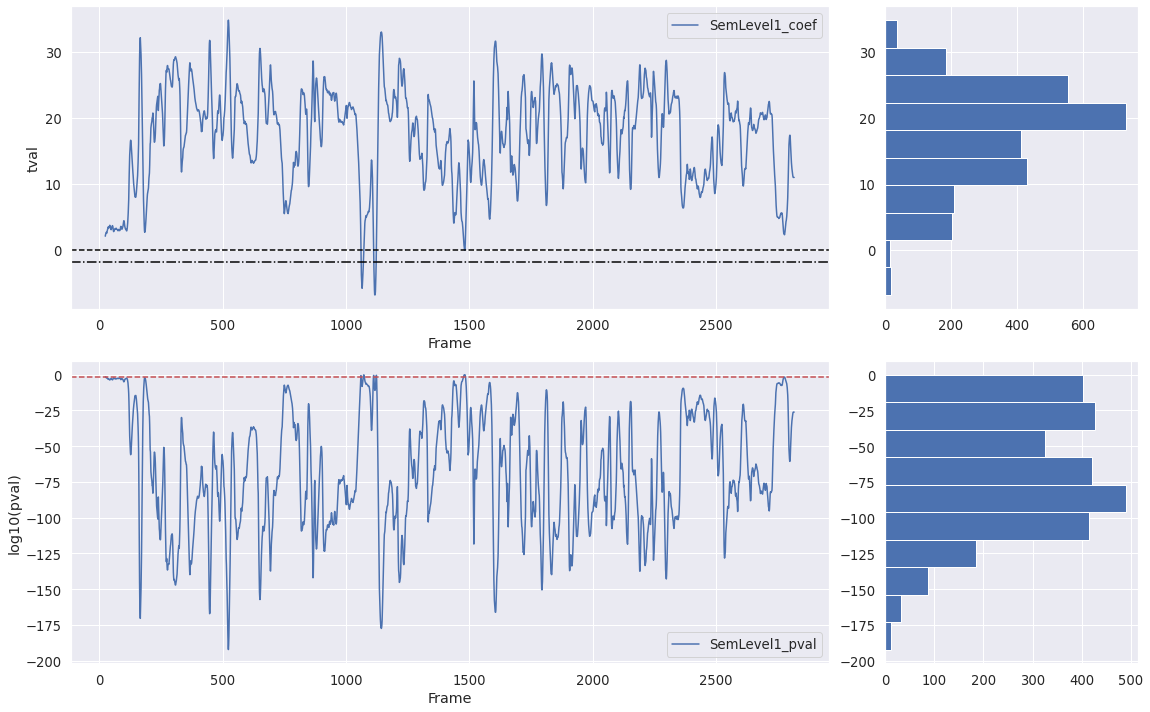

In [12]:
tval , pval = plot_coefficients_frames(models_path=models_path, coef_name=['SemLevel1'])

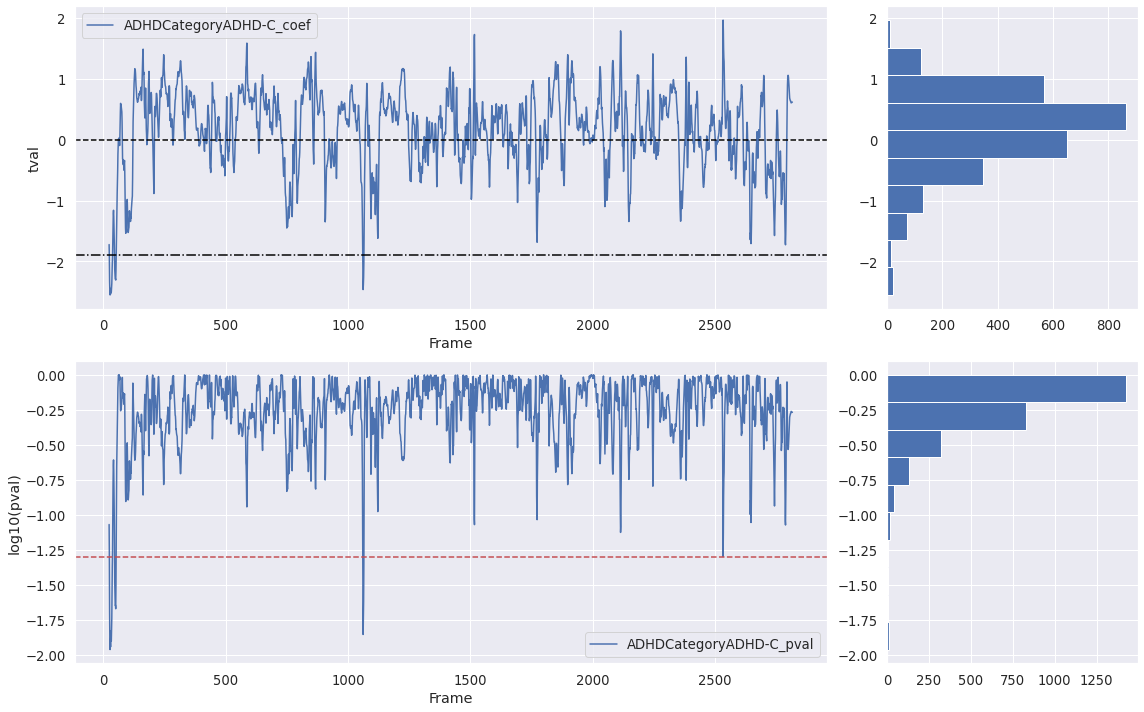

In [13]:
tval , pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-C'])

In [14]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,ADHDCategoryADHD-C_pval
1039,1063,-1.758557
11,35,-1.738317
4,28,-1.963014
1040,1064,-1.621031
24,48,-1.562882
5,29,-1.891150
12,36,-1.530710
7,31,-1.832052
6,30,-1.944171
26,50,-1.645610


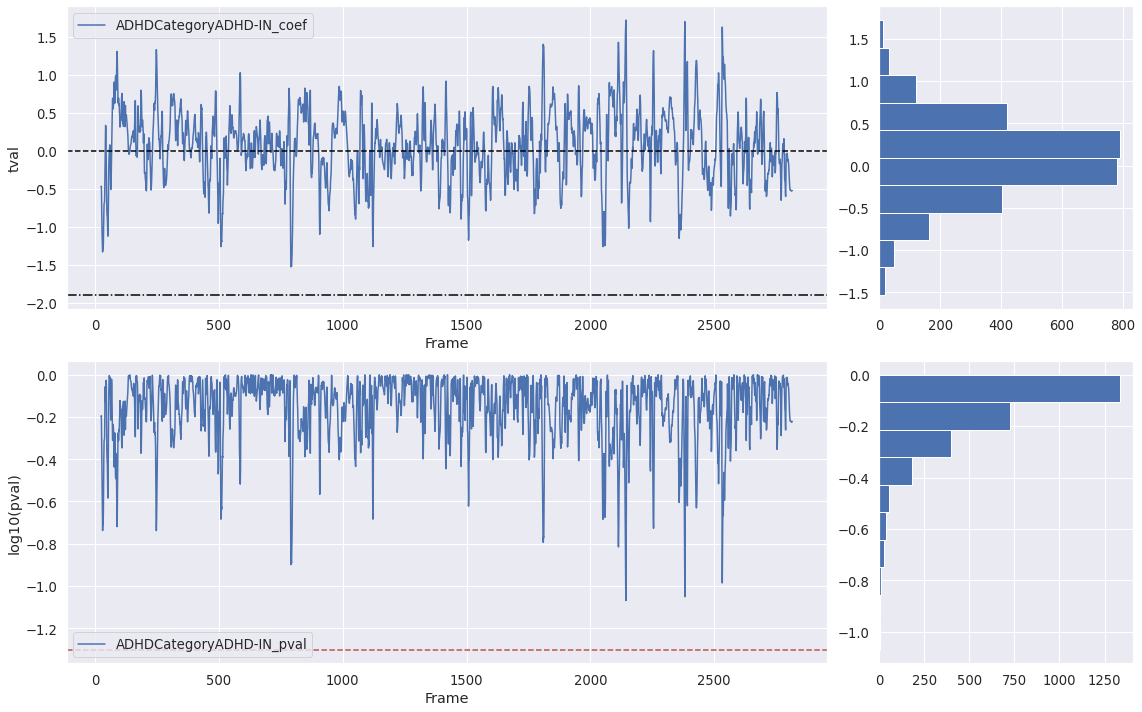

In [15]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-IN'])

In [16]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(0, 2)


## Effects of interaction

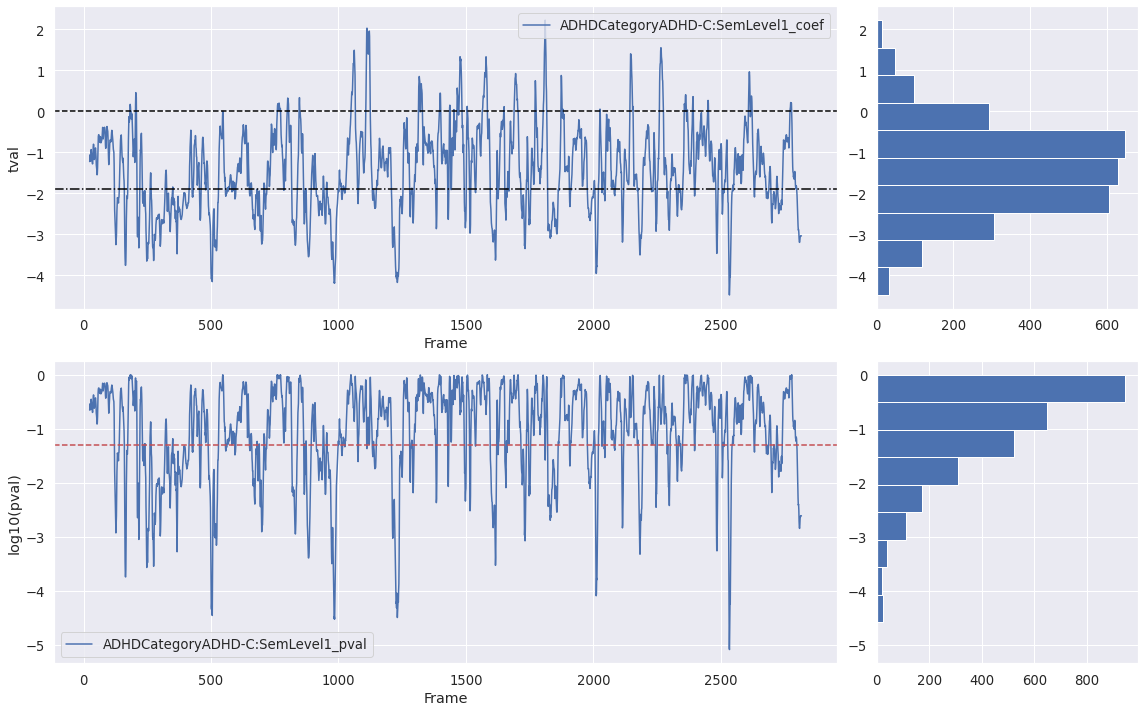

In [17]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-C:SemLevel1'])

In [18]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,ADHDCategoryADHD-C:SemLevel1_pval
572,596,-1.430677
648,672,-2.393859
2692,2716,-1.628731
675,699,-2.906331
2707,2731,-1.781291
1261,1285,-1.349696
630,654,-1.387749
2019,2043,-1.373410
803,827,-2.347585
1727,1751,-2.211377


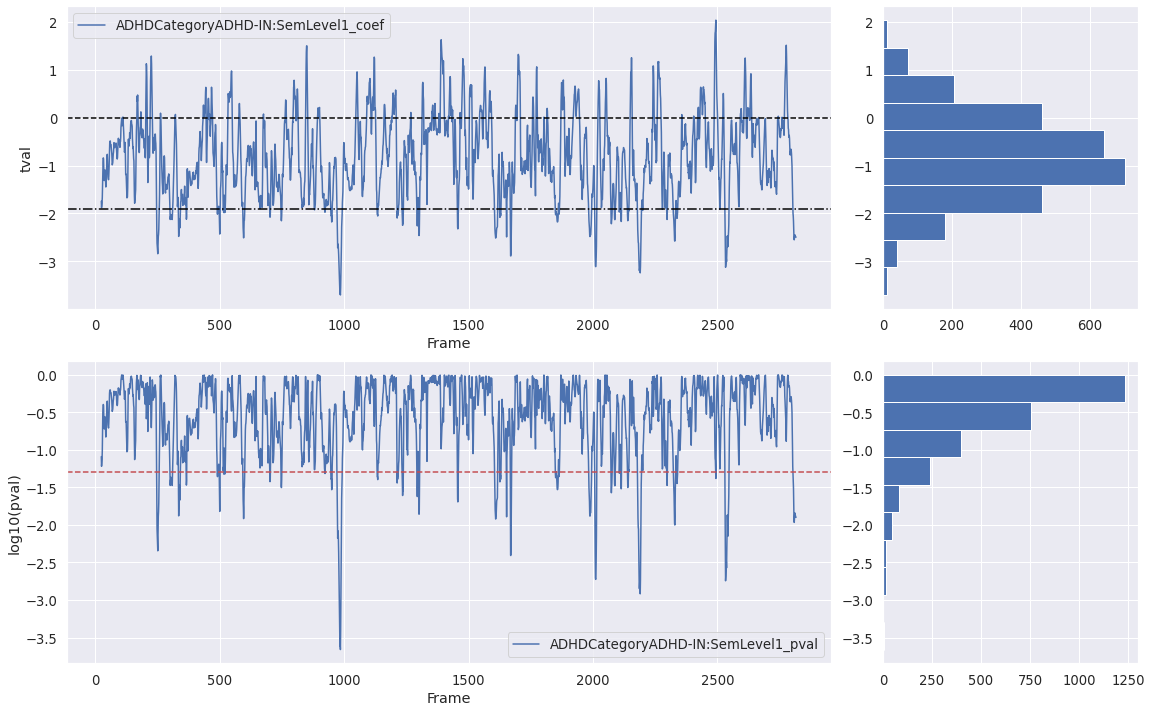

In [19]:
tval, pval = plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-IN:SemLevel1'])

# Fixed effects - Scenes

In [20]:
#scenes_data =  pd.read_csv('../videos_data/Diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
scenes_data = pd.read_csv('/hdd/ReposPesados/SaliencyADHD/videos_data/Diary/scenes/ManualSceneCut_WK.csv', 
                          sep=';').rename(columns={'SceneNumber': 'Scene Number','StartFrame':'Start Frame', 'EndFrame':'End Frame'})

## Effects of variables

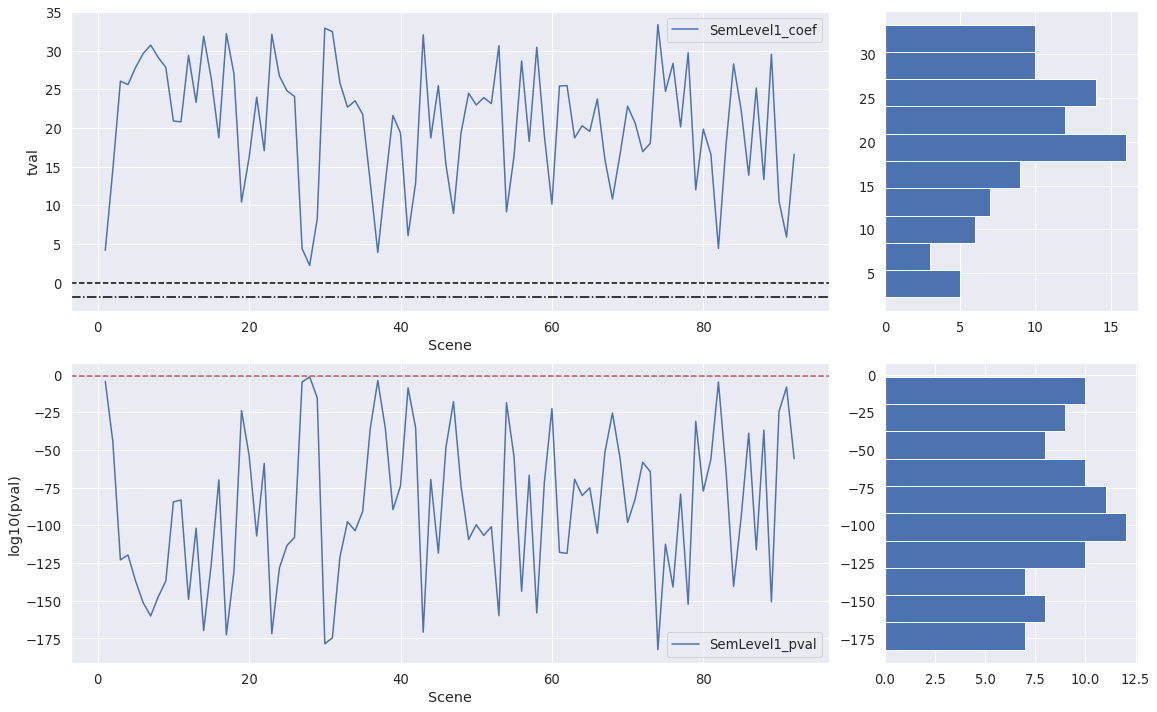

In [21]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['SemLevel1'], is_scenes=True)

In [22]:
pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)

,Frame,SemLevel1_pval
79,80,-77.322955
74,75,-112.507557
4,5,-136.822813
54,55,-54.674077
41,42,-35.411673
82,83,-63.693942
84,85,-94.707481
81,82,-4.960095
71,72,-58.180904
50,51,-106.698301


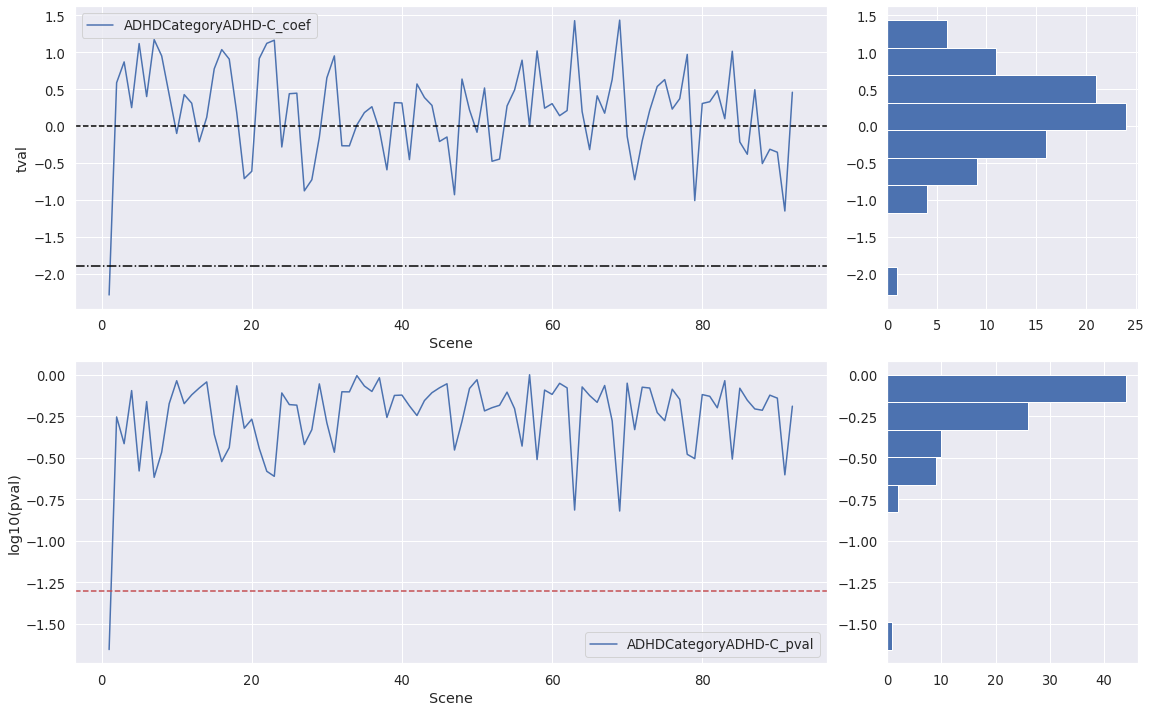

In [23]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-C'], is_scenes=True)

In [24]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(1, 2)


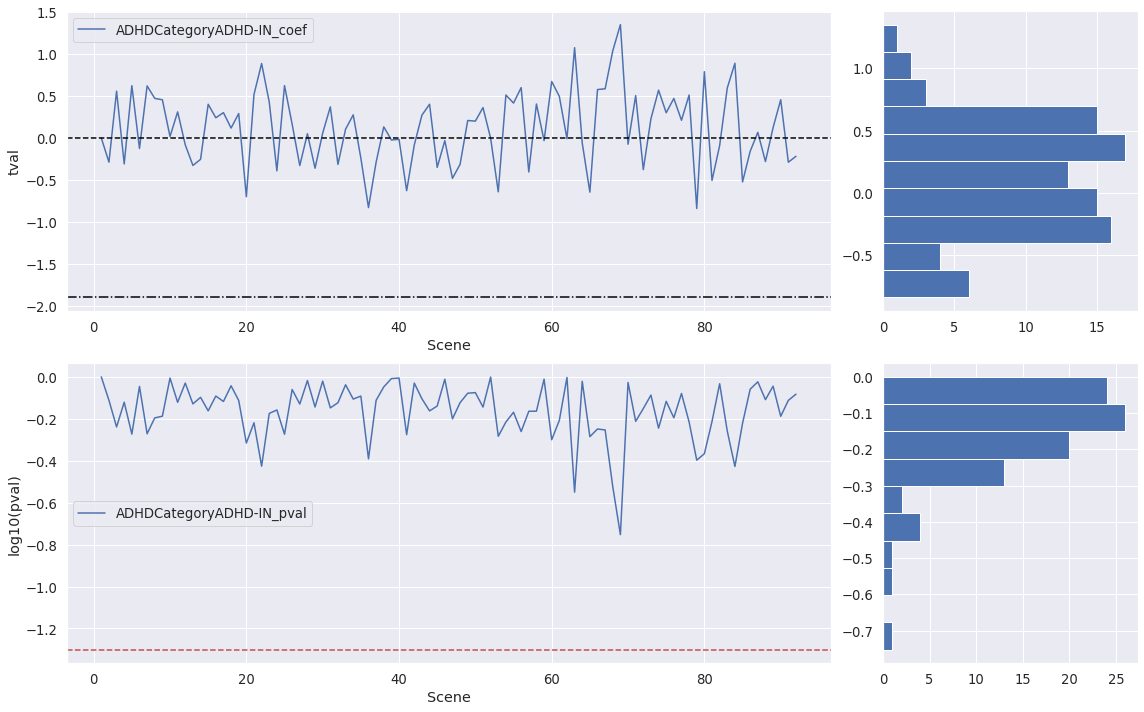

In [25]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-IN'], is_scenes=True)

In [26]:
try: 
    pval[pval.iloc[:,1] < np.log10(0.05)].sample(10)
except:
    print(pval[pval.iloc[:,1] < np.log10(0.05)].shape)

(0, 2)


## Effects of interaction

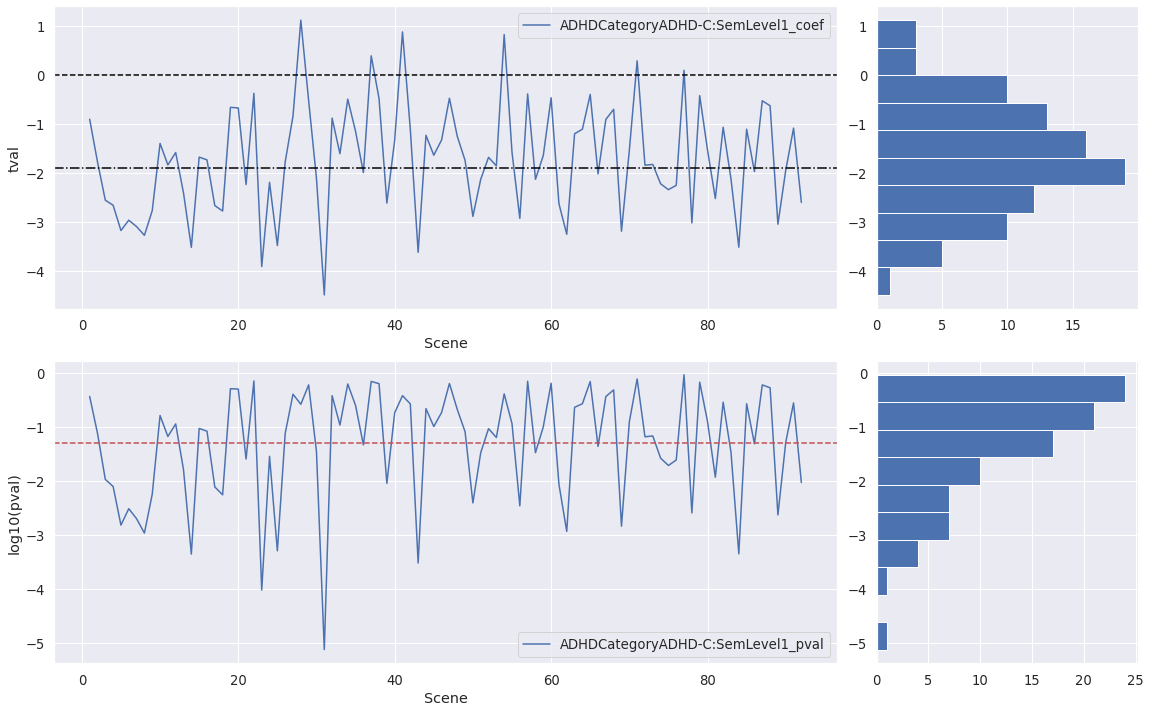

In [27]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-C:SemLevel1'], is_scenes=True)

In [28]:
pval[pval.iloc[:,1] < np.log10(0.05)].shape#.sample(10)

(38, 2)

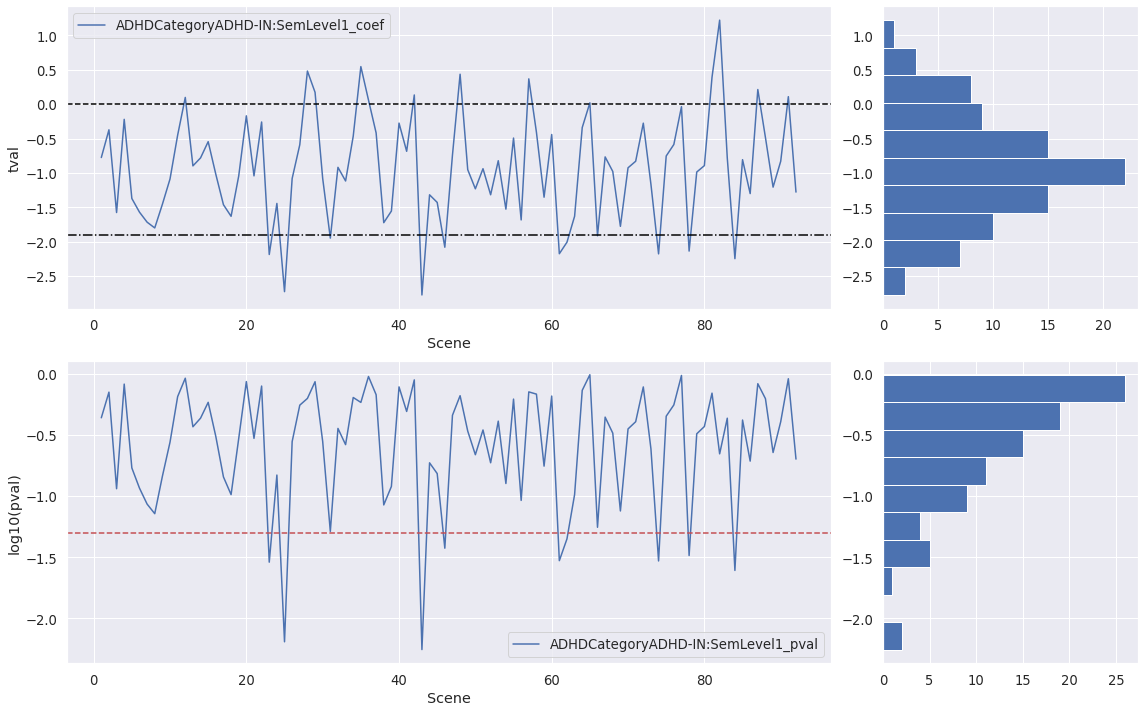

In [29]:
tval, pval = plot_coefficients_frames(models_path=models_path_scenes, coef_name=['ADHDCategoryADHD-IN:SemLevel1'], is_scenes=True)

In [30]:
pval[pval.iloc[:,1] < np.log10(0.05)].sort_values(by='Frame')['Frame'].values
#.sample(10)

array([23, 25, 43, 46, 61, 62, 74, 78, 84])

In [32]:
pval

,Frame,ADHDCategoryADHD-IN:SemLevel1_pval
0,1,-0.359141
1,2,-0.149311
2,3,-0.939554
3,4,-0.083468
4,5,-0.769461
...,...,...
87,88,-0.202509
88,89,-0.643222
89,90,-0.391276
90,91,-0.039518


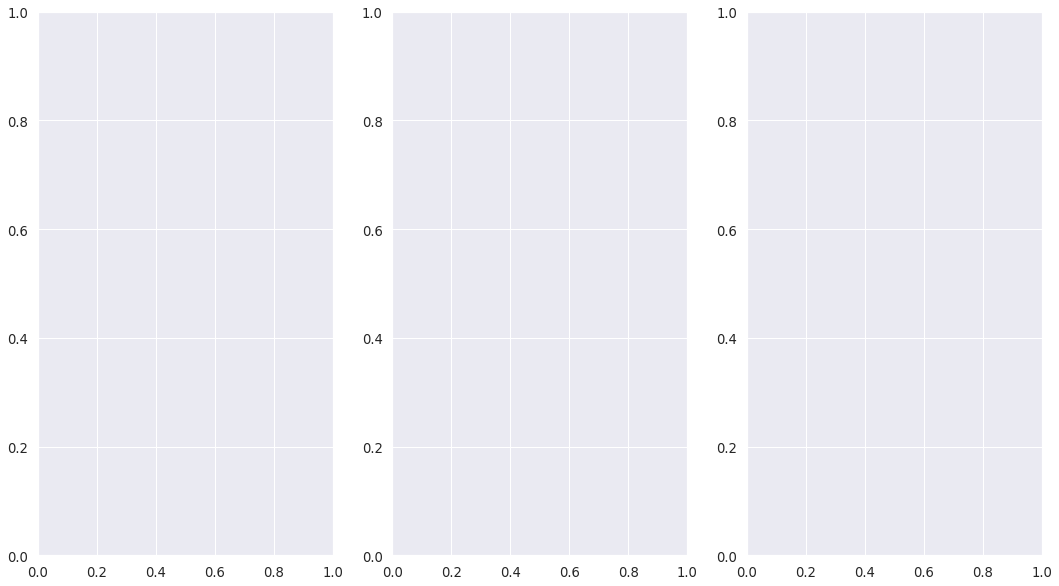

In [31]:
plot_sample_scenes(66, video_name='Diary', images_path='../videos_data/')